# The multi-derivative DRAG pulse

In [8]:
import logging
from copy import deepcopy
import numpy as np
from numpy import pi
from qiskit.circuit import Gate
from qiskit import transpile
from qiskit.transpiler import InstructionProperties
from qiskit_utilities import (
    save_job_data,
    setup_logger,
    retrive_expdata,
    get_cr_schedule,
    iy_drag_calibration,
    get_default_cr_params,
    read_calibration_data,
    iterative_cr_pulse_calibration,
    create_echoed_cnot_schedule,
    initilize_qiskit_dynamics_backend
)
session = None  # qiskit runtime session

Setup a logging system.

In [9]:
# Setup a logging system.
setup_logger(filename=None, level=logging.INFO, stdout=True)
logger = logging.getLogger("qiskit_utilities")

2024-04-25 12:07:48,739, MainThread 
INFO Logger initialized successfully.


Setup a simulator backend based on qiksit-dynamics and calibrate the single-qubit gates using the default calibrations from qiskit-experiment.

In [10]:
# Create a qiskit-dynamics backend with two Transmon, see fake_backend.py for detail.
# fidelity
f0 = 5.188339840468758e9
f1 = 5.079647268847252e9
# anharmonicity
a0 = -0.341931669003125e9
a1 = -0.343248404293835e9
backend = initilize_qiskit_dynamics_backend(f0, f1, a0, a1, J=0.003e9)

## Recursive DRAG pulse

### Hann pulse ramping time t_r=10ns

First, we reduce the ramping time to 10 ns (instead of 28.4 ns) and use a Hann pulse, which is similar to Gaussian shape. A short ramping time like this will introduce transition error on the first qubit.

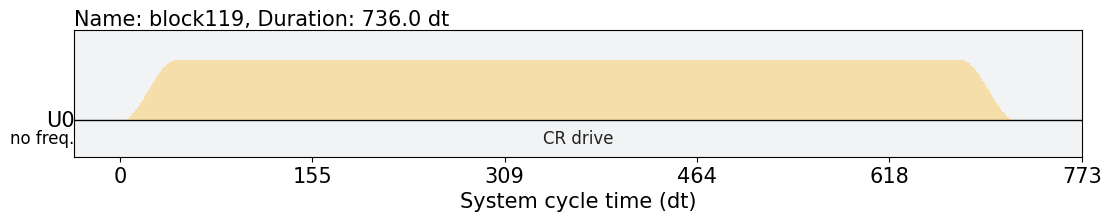

In [11]:
# Operating qubits
QUBIT_C, QUBIT_T = (0, 1)
# Compute the sampling time steps for the CR tomography experiments
if backend.name == 'DynamicsBackend':
    amp = 2 * pi * 0.04
    cr_times = np.arange(16*16, 1440*3, 32*4, dtype=int)
    duration = 720  # Used for plotting only, not tomography.
else:
    amp = get_default_cr_params(backend, QUBIT_C, QUBIT_T)[0]
    duration = backend.defaults().instruction_schedule_map.get("cx", (QUBIT_C, QUBIT_T)).duration/16 * 4
    cr_times = 16 * np.arange(16, duration + 16, duration//30, dtype=int)


## Custom shape
gate_name = "CR-Hann-tr10"
params = {
    "order": "1",  # order m for the initial pulse shape, order 1 is the Hann shape
    "t_r": 10,
    "drag_type" : False,  # Givens rotation, use "sw" for perturbation
    "duration": duration,  # only for plotting
    "amp": amp,
    "angle": 0.0,
    ## If real device, use the following
    # "Delta": (backend.properties().frequency(QUBIT_C) - backend.properties().frequency(QUBIT_T)) * 1.0e-9 * 2 * pi,
    # "a1": 2 * pi * backend.properties().qubit_property(QUBIT_C)["anharmonicity"][0] * 1.0e-9,
    ## If Dynamicsbackend, use this
    "Delta": 2 * pi * (f0 - f1) * 1.0e-9,
    "a1": 2 * pi * a0 * 1.0e-9,
    "drag_scale": [1., 1., 1.],
}
cr_params = params.copy()
ix_params = params.copy()
ix_params["amp"] = 0.0
ix_params["order"] = "2"

initial_calibration_data = {
    "cr_params": cr_params,
    "ix_params": ix_params,
    "frequency_offset": 0.,
}

get_cr_schedule((QUBIT_C, QUBIT_T), backend, cr_params=cr_params, ix_params=ix_params).draw()

2024-04-25 12:09:00,824, MainThread 
INFO Target IX / ZX ratio: 0.0
2024-04-25 12:09:00,825, MainThread 
INFO 

CR calibration round 1: 
2024-04-25 12:09:01,613, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 12:10:35,772, MainThread 
INFO CR tomography: 75c165d8-6e22-47fe-9a71-5ca20b8723ed
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '1', 't_r': 10, 'drag_type': False, 'duration': 720, 'amp': 0.25132741228718347, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': False, 'duration': 720, 'amp': 0.0, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
x_gate_ix_params: None
frequency_offset: 0.0
dt: 2.2222222222222221e-10


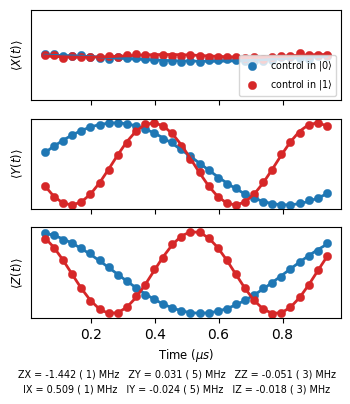

2024-04-25 12:10:36,561, MainThread 
INFO Tomography results:
{'IX': 0.5089890414708043, 'IY': -0.024064339681554057, 'IZ': -0.018428238664989913, 'ZX': -1.4424382568676684, 'ZY': 0.03138108698478474, 'ZZ': -0.05054953580272845}

2024-04-25 12:10:36,562, MainThread 
INFO Frequency offset is updated to -18428.238664989913 Hz
2024-04-25 12:10:36,562, MainThread 
INFO Remaining dominant error: IX: 0.5089890414708043 MHz

2024-04-25 12:10:36,563, MainThread 
INFO Omega[GHz]/amp: 0.15915494309189535
2024-04-25 12:10:36,563, MainThread 
INFO Probe amp shift [MHz]: -0.5089890414708043 MHz
2024-04-25 12:10:36,563, MainThread 
INFO Probe amp shift (amp): -0.0031980724668847784
2024-04-25 12:10:37,361, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 12:12:11,197, MainThread 
INFO CR tomography: b845d76b-ed1b-4106-a530-f7b11c9b779b
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560

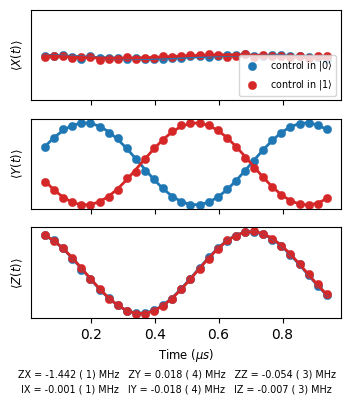

2024-04-25 12:12:12,098, MainThread 
INFO {'IX': -0.0009495955002245723, 'IY': -0.01788294124510896, 'IZ': -0.007199502874175639, 'ZX': -1.4419280058318389, 'ZY': 0.017924564500743582, 'ZZ': -0.05374215440798839}
2024-04-25 12:12:12,099, MainThread 
INFO Estimated drive scale: 
(0.15945187054118157-0.0019328512722747515j)
(0.15946358497513616+0j)
-0.01212125391522721
2024-04-25 12:12:12,101, MainThread 
INFO CR calibration data saved.
2024-04-25 12:12:12,103, MainThread 
INFO 

CR calibration round 2: 
2024-04-25 12:12:12,948, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 12:13:44,554, MainThread 
INFO CR tomography: 94a6e60e-0d59-4648-96a6-232154305142
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '1', 't_r': 10, 'drag_type': False, 'duration': 720, 'amp': 0.251327

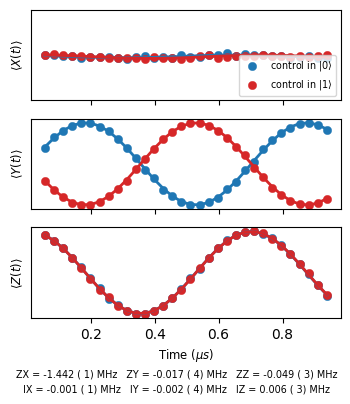

2024-04-25 12:13:45,523, MainThread 
INFO Tomography results:
{'IX': -0.0010111343257906444, 'IY': -0.0024010402147785345, 'IZ': 0.00628149613962778, 'ZX': -1.442348360272822, 'ZY': -0.017257958999031302, 'ZZ': -0.04937467126425759}

2024-04-25 12:13:45,524, MainThread 
INFO Remaining dominant error: ZY: 0.017257958999031302 MHz

2024-04-25 12:13:45,525, MainThread 
INFO Omega[GHz]/amp: 0.15946358497513616
2024-04-25 12:13:45,526, MainThread 
INFO Probe amp shift [MHz]: 0.1 MHz
2024-04-25 12:13:45,526, MainThread 
INFO Probe amp shift (amp): 0.0006271024197505166
2024-04-25 12:13:46,319, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 12:15:19,735, MainThread 
INFO CR tomography: 67b69e59-5c79-4d0f-8730-c7cd92a5a3b8
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '1', '

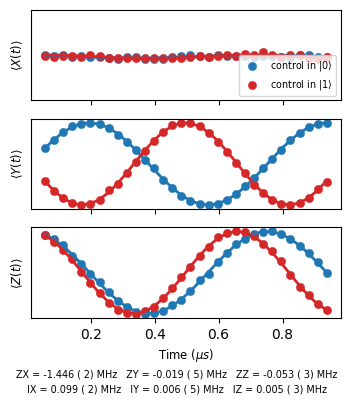

2024-04-25 12:15:20,542, MainThread 
INFO {'IX': 0.0993735860370419, 'IY': 0.0061930868935437845, 'IZ': 0.004715286619458839, 'ZX': -1.4458244596611685, 'ZY': -0.0194578828706855, 'ZZ': -0.05272053301032273}
2024-04-25 12:15:20,543, MainThread 
INFO Estimated drive scale: 
(0.1600770738578383+0.013704503184250776j)
(0.1606626371699872+0j)
0.08540365843330536
2024-04-25 12:15:20,544, MainThread 
INFO CR calibration data saved.
2024-04-25 12:15:20,545, MainThread 
INFO 

CR calibration round 3: 
2024-04-25 12:15:21,354, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 12:16:56,331, MainThread 
INFO CR tomography: b76ac369-1542-40d3-92ed-d66662fd6338
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '1', 't_r': 10, 'drag_type': False, 'duration': 720, 'amp': 0.251327412287183

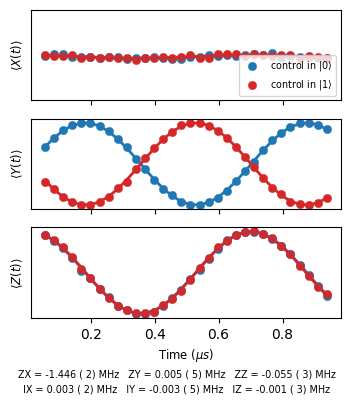

2024-04-25 12:16:57,398, MainThread 
INFO Tomography results:
{'IX': 0.003199658083725089, 'IY': -0.00330423214830144, 'IZ': -0.0014948487971988716, 'ZX': -1.445637230792757, 'ZY': 0.005249260997296287, 'ZZ': -0.054959966211251446}

2024-04-25 12:16:57,400, MainThread 
INFO Remaining dominant error: ZY: 0.005249260997296287 MHz

2024-04-25 12:16:57,400, MainThread 
INFO Successfully calibrated.
2024-04-25 12:16:57,403, MainThread 
INFO CR calibration data saved.


In [12]:
iterative_cr_pulse_calibration(
    (QUBIT_C, QUBIT_T),
    backend,
    initial_calibration_data=initial_calibration_data,
    cr_times=cr_times,
    session=session,
    gate_name=gate_name,
    verbose=True,
    restart=True,  # fresh start
    max_repeat=3,
    shots=2048,
    mode="CR",
    )

2024-04-25 12:17:48,479, MainThread 
INFO Quantum process tomography job: aa554aa0-420d-488a-abda-231badc43150
backend: DynamicsBackend
qubits: (0, 1)
shots: 8096

2024-04-25 12:17:48,848, MainThread 
INFO Job saved to data/aa554aa0-420d-488a-abda-231badc43150



(<Figure size 800x600 with 2 Axes>,
 <Axes3D: title={'center': 'Process Matrix'}>)

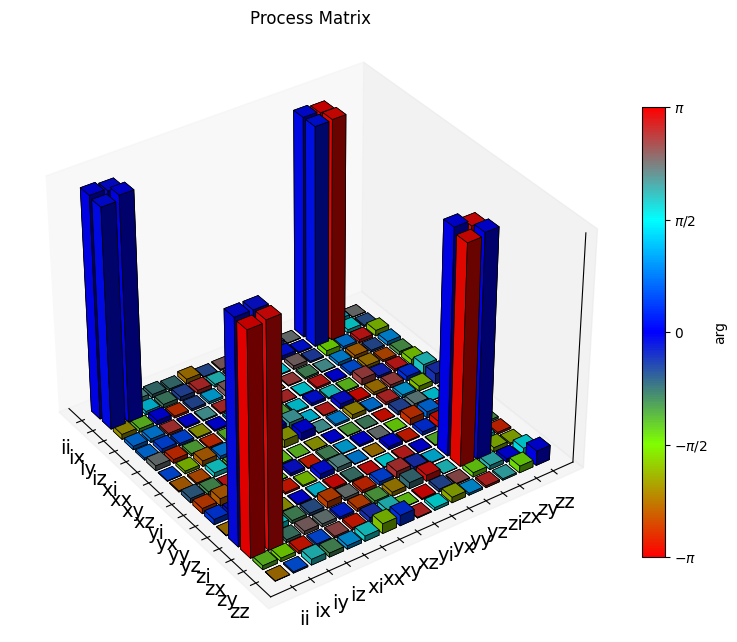

In [13]:
from qiskit_experiments.library import ProcessTomography
calibration_data = read_calibration_data(backend, gate_name, (QUBIT_C, QUBIT_T))

custom_cnot_sched = create_echoed_cnot_schedule(backend, (QUBIT_C, QUBIT_T), calibration_data, reverse_direction=False)

# Show the custom CNOT schedule.
custom_cnot_sched.draw()

custom_cnot = Gate("custom_cnot", 2, [])
backend_tmp = deepcopy(backend)
backend_tmp.target.add_instruction(
    custom_cnot,
    {(QUBIT_C, QUBIT_T): InstructionProperties(calibration=custom_cnot_sched)},
    name="custom_cnot",
)
qptexp = ProcessTomography(custom_cnot, physical_qubits=[QUBIT_C, QUBIT_T])

try:
    basis_gates = backend.configuration().basis_gates
except AttributeError:
    basis_gates = ["measure", "sx", "x", "rz"]
transpiled_circ_list = transpile(
    qptexp._transpiled_circuits(),
    backend=backend_tmp,
    basis_gates = basis_gates + ["custom_cnot"],
    optimization_level= 1,  # Turn off optimization to keep the custom pulse
    )

shots = 8096
if session is not None:
    qpt_job = session.run(
        "circuit-runner",
        inputs={
            "circuits": transpiled_circ_list,
            "skip_transpilation": True,
            "shots": shots,
        },
    )
else:
    qpt_job = backend.run(transpiled_circ_list, shots=shots)

parameters = {
    "backend": backend.name,
    "qubits": (QUBIT_C, QUBIT_T),
    "shots": shots,
    }
logger.info(
    "Quantum process tomography job: "+
    str(qpt_job.job_id()) + "\n"
    + "\n".join([f"{key}: {val}" for key, val in parameters.items()])
    + "\n"
    )

save_job_data(qpt_job, backend=backend, parameters=parameters)

import qutip
qptdata = retrive_expdata(qpt_job, backend=backend, exp=qptexp)

state_result = qptdata.analysis_results("state")
choi_matrix = state_result.value.data
choi_qobj = qutip.Qobj(
    choi_matrix, dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]], superrep="choi"
)
choi_qobj = choi_qobj.permute([[1, 0], [3, 2]])  # Permute the two qubit
qutip.to_super(choi_qobj)
op_basis = [[qutip.qeye(2), qutip.sigmax(), qutip.sigmay(), qutip.sigmaz()]] * 2
chi_qobj = qutip.qpt(qutip.to_super(choi_qobj), op_basis)
qutip.qpt_plot_combined(
    chi_qobj, lbls_list=[["i", "x", "y", "z"]] * 2, title="Process Matrix"
)

Although we don't measure the leakage here, we can see from the plot above that there are more error than the tomography for longer-ramping pulse.

### Recursive DRAG pulse ramping time t_r=10ns

Using the same 10 ns pulse ramping time, we now use the recursive DRAG derived from Givens rotation.

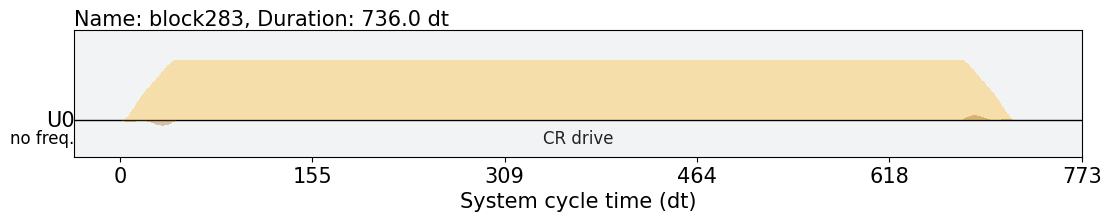

In [14]:
# Operating qubits
QUBIT_C, QUBIT_T = (0, 1)
# Compute the sampling time steps for the CR tomography experiments
if backend.name == 'DynamicsBackend':
    amp = 2 * pi * 0.04
    cr_times = np.arange(16*16, 1440*3, 32*4, dtype=int)
    duration = 720  # Used for plotting only, not tomography.
else:
    amp = get_default_cr_params(backend, QUBIT_C, QUBIT_T)[0]
    duration = backend.defaults().instruction_schedule_map.get("cx", (QUBIT_C, QUBIT_T)).duration/16 * 4
    cr_times = 16 * np.arange(16, duration + 16, duration//30, dtype=int)


## Custom shape
gate_name = "CR-recursive-tr10"
params = {
    "order": "3",  # order m for the initial pulse shape, order 1 is the Hann shape
    "t_r": 10,
    "drag_type" : "exact",  # Givens rotation, use "sw" for perturbation
    "duration": duration,  # only for plotting
    "amp": amp,
    "angle": 0.0,
    ## If real device, use the following
    # "Delta": (backend.properties().frequency(QUBIT_C) - backend.properties().frequency(QUBIT_T)) * 1.0e-9 * 2 * pi,
    # "a1": 2 * pi * backend.properties().qubit_property(QUBIT_C)["anharmonicity"][0] * 1.0e-9,
    ## If Dynamicsbackend, use this
    "Delta": 2 * pi * (f0 - f1) * 1.0e-9,
    "a1": 2 * pi * a0 * 1.0e-9,
    "drag_scale": [1., 1., 1.],
}
cr_params = params.copy()
ix_params = params.copy()
ix_params["amp"] = 0.0
ix_params["order"] = "2"

initial_calibration_data = {
    "cr_params": cr_params,
    "ix_params": ix_params,
    "frequency_offset": 0.,
}
get_cr_schedule((QUBIT_C, QUBIT_T), backend, cr_params=cr_params, ix_params=ix_params).draw()

2024-04-25 12:18:00,763, MainThread 
INFO Target IX / ZX ratio: 0.0
2024-04-25 12:18:00,765, MainThread 
INFO 

CR calibration round 1: 
2024-04-25 12:21:49,900, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 12:23:28,667, MainThread 
INFO CR tomography: 1df81dc1-8411-4acf-8040-0e72c858fa61
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.0, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
x_gate_ix_params: None
frequency_offset: 0.0
dt: 2.2222222222222221e

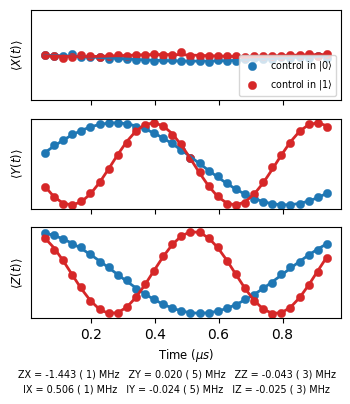

2024-04-25 12:23:29,668, MainThread 
INFO Tomography results:
{'IX': 0.506223817990196, 'IY': -0.02402608566888709, 'IZ': -0.02485988972759867, 'ZX': -1.4430380444923994, 'ZY': 0.01974367199779545, 'ZZ': -0.04319933324982666}

2024-04-25 12:23:29,669, MainThread 
INFO Frequency offset is updated to -24859.889727598667 Hz
2024-04-25 12:23:29,669, MainThread 
INFO Remaining dominant error: IX: 0.506223817990196 MHz

2024-04-25 12:23:29,670, MainThread 
INFO Omega[GHz]/amp: 0.15915494309189535
2024-04-25 12:23:29,670, MainThread 
INFO Probe amp shift [MHz]: -0.506223817990196 MHz
2024-04-25 12:23:29,670, MainThread 
INFO Probe amp shift (amp): -0.003180698055340352
2024-04-25 12:28:17,797, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 12:29:52,687, MainThread 
INFO CR tomography: 5f9e2499-a2c9-4266-a778-000a83663a35
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 

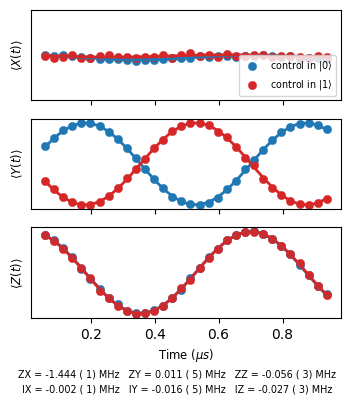

2024-04-25 12:29:53,716, MainThread 
INFO {'IX': -0.001840285067187075, 'IY': -0.016368408866808914, 'IZ': -0.026945820161717655, 'ZX': -1.4441362854777795, 'ZY': 0.011363413124061006, 'ZZ': -0.05556029227199524}
2024-04-25 12:29:53,717, MainThread 
INFO Estimated drive scale: 
(0.15973352208152855-0.002407545975393997j)
(0.15975166463669108+4.440387758655086e-19j)
-0.01507112382495668
2024-04-25 12:29:53,718, MainThread 
INFO CR calibration data saved.
2024-04-25 12:29:53,719, MainThread 
INFO 

CR calibration round 2: 
2024-04-25 12:34:52,063, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 12:36:27,252, MainThread 
INFO CR tomography: 758c9dac-6ec5-4fc3-af66-aa405c90ae19
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration':

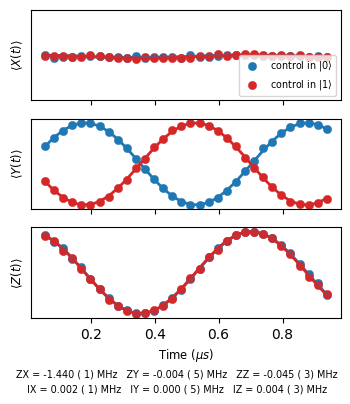

2024-04-25 12:36:28,238, MainThread 
INFO Tomography results:
{'IX': 0.0016232851915638916, 'IY': 0.000141738962015598, 'IZ': 0.003994215959970979, 'ZX': -1.4401767511866563, 'ZY': -0.003986655097213101, 'ZZ': -0.04509725719245311}

2024-04-25 12:36:28,239, MainThread 
INFO Remaining dominant error: ZY: 0.003986655097213101 MHz

2024-04-25 12:36:28,239, MainThread 
INFO Successfully calibrated.
2024-04-25 12:36:28,247, MainThread 
INFO CR calibration data saved.


In [15]:
iterative_cr_pulse_calibration(
    (QUBIT_C, QUBIT_T),
    backend,
    initial_calibration_data=initial_calibration_data,
    cr_times=cr_times,
    session=session,
    gate_name=gate_name,
    verbose=True,
    restart=True,  # fresh start
    max_repeat=3,
    shots=2048,
    mode="CR",
    )

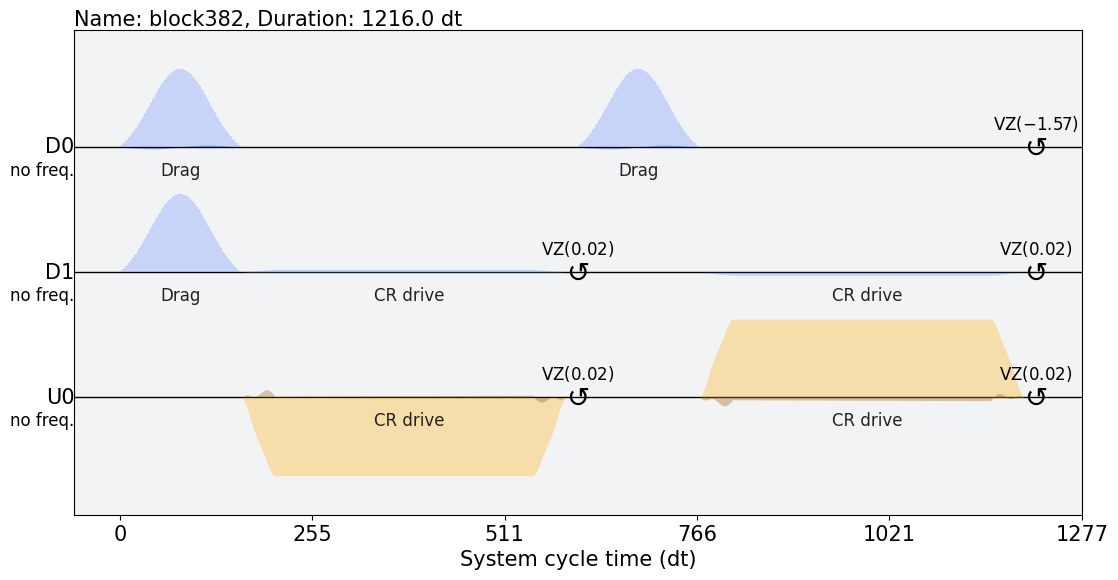

In [16]:
from qiskit_experiments.library import ProcessTomography
calibration_data = read_calibration_data(backend, gate_name, (QUBIT_C, QUBIT_T))

custom_cnot_sched = create_echoed_cnot_schedule(backend, (QUBIT_C, QUBIT_T), calibration_data, reverse_direction=False)

# Show the custom CNOT schedule.
custom_cnot_sched.draw()

2024-04-25 12:37:32,195, MainThread 
INFO Quantum process tomography job: c12992a9-305b-4c6c-903b-c3c0575581fb
backend: DynamicsBackend
qubits: (0, 1)
shots: 8096

2024-04-25 12:37:32,721, MainThread 
INFO Job saved to data/c12992a9-305b-4c6c-903b-c3c0575581fb



(<Figure size 800x600 with 2 Axes>,
 <Axes3D: title={'center': 'Process Matrix'}>)

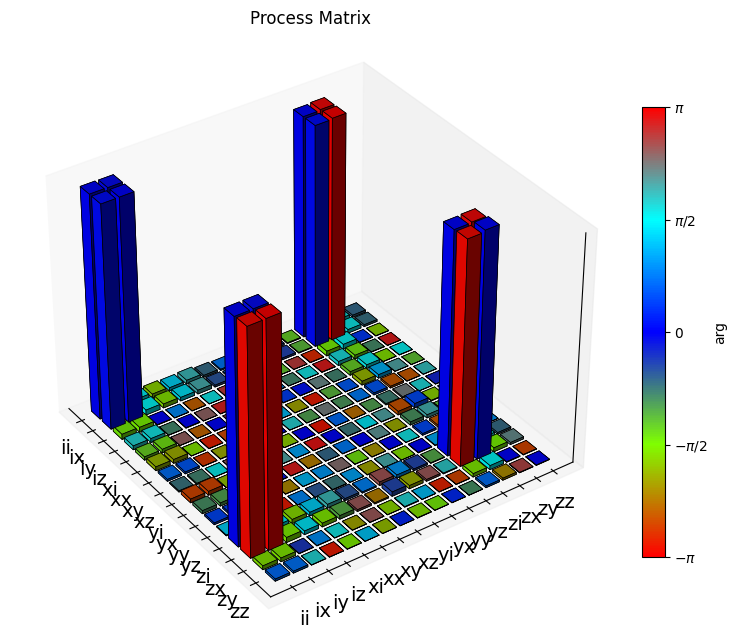

In [17]:
custom_cnot = Gate("custom_cnot", 2, [])
backend_tmp = deepcopy(backend)
backend_tmp.target.add_instruction(
    custom_cnot,
    {(QUBIT_C, QUBIT_T): InstructionProperties(calibration=custom_cnot_sched)},
    name="custom_cnot",
)
qptexp = ProcessTomography(custom_cnot, physical_qubits=[QUBIT_C, QUBIT_T])

try:
    basis_gates = backend.configuration().basis_gates
except AttributeError:
    basis_gates = ["measure", "sx", "x", "rz"]
transpiled_circ_list = transpile(
    qptexp._transpiled_circuits(),
    backend=backend_tmp,
    basis_gates = basis_gates + ["custom_cnot"],
    optimization_level= 1,  # Turn off optimization to keep the custom pulse
    )

shots = 8096
if session is not None:
    qpt_job = session.run(
        "circuit-runner",
        inputs={
            "circuits": transpiled_circ_list,
            "skip_transpilation": True,
            "shots": shots,
        },
    )
else:
    qpt_job = backend.run(transpiled_circ_list, shots=shots)

parameters = {
    "backend": backend.name,
    "qubits": (QUBIT_C, QUBIT_T),
    "shots": shots,
    }
logger.info(
    "Quantum process tomography job: "+
    str(qpt_job.job_id()) + "\n"
    + "\n".join([f"{key}: {val}" for key, val in parameters.items()])
    + "\n"
    )

save_job_data(qpt_job, backend=backend, parameters=parameters)

import qutip
qptdata = retrive_expdata(qpt_job, backend=backend, exp=qptexp)

state_result = qptdata.analysis_results("state")
choi_matrix = state_result.value.data
choi_qobj = qutip.Qobj(
    choi_matrix, dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]], superrep="choi"
)
choi_qobj = choi_qobj.permute([[1, 0], [3, 2]])  # Permute the two qubit
qutip.to_super(choi_qobj)
op_basis = [[qutip.qeye(2), qutip.sigmax(), qutip.sigmay(), qutip.sigmaz()]] * 2
chi_qobj = qutip.qpt(qutip.to_super(choi_qobj), op_basis)
qutip.qpt_plot_combined(
    chi_qobj, lbls_list=[["i", "x", "y", "z"]] * 2, title="Process Matrix"
)

## Calibration of the IY DRAG to suppress ZZ error
We Calibrate the IY-DRAG amplitude to suppress the ZZ error. We first perform three experiments with different beta parameters and then perform a linear fit.
- If the default Gaussian pulse is used, refer to the qiskit DRAG pulse for the definition of beta.
- If the custom DRAG pulse is used, `beta` refers to the constant scaling coefficient for the DRAG correction term.

2024-04-25 12:37:37,343, MainThread 
INFO 
Calibrating the IY-DRAG pulse for (0, 1)-CR-recursive-tr10.
2024-04-25 12:42:08,757, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 12:43:44,910, MainThread 
INFO CR tomography: d92511fd-a84f-4e1f-a636-00492e8ed312
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.013681164001267022, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp': -0.0031707238550928133, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': 0.0}
x_gate_ix_params: None
frequency_offset: -24859.8897275

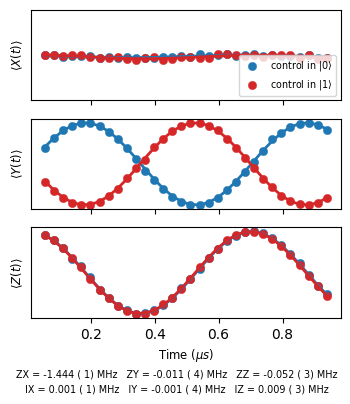

2024-04-25 12:48:15,900, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 12:49:47,548, MainThread 
INFO CR tomography: 55f42b14-4a70-430c-894d-db23efd6da4e
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 1024
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.013681164001267022, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp': -0.0031707238550928133, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': -10.0}
x_gate_ix_params: None
frequency_offset: -24859.889727598667
dt: 2.2222222222222221e-10

2024-04-25 12:49:47,972, MainThread 
INFO Job saved to data/55f42b1

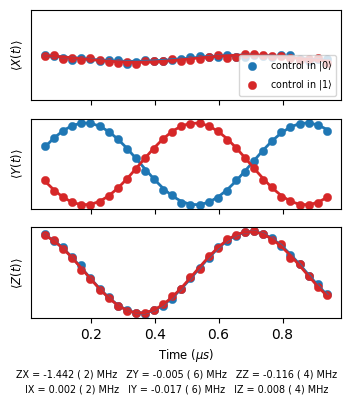

2024-04-25 12:54:21,106, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 12:55:54,872, MainThread 
INFO CR tomography: 693bc544-0065-4331-b115-80bd6e009f41
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 1024
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.013681164001267022, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp': -0.0031707238550928133, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': 10.0}
x_gate_ix_params: None
frequency_offset: -24859.889727598667
dt: 2.2222222222222221e-10

2024-04-25 12:55:55,272, MainThread 
INFO Job saved to data/693bc544

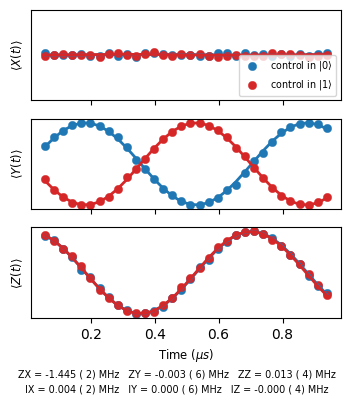

2024-04-25 12:55:55,846, MainThread 
INFO ZZ sampling measurements complete : [-0.05181688682518958, -0.1156030801845223, 0.013235260350670143].

2024-04-25 12:55:55,847, MainThread 
INFO Calibrated IY beta: 7.978199968454572



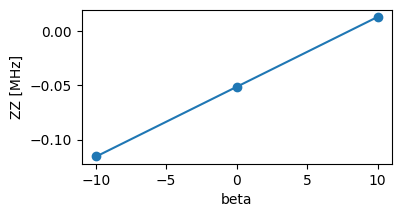

2024-04-25 13:00:17,727, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 13:01:52,461, MainThread 
INFO CR tomography: d89da855-000a-491a-be7b-2534d834a471
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.013681164001267022, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp': -0.0031707238550928133, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': 7.978199968454572}
x_gate_ix_params: None
frequency_offset: -24859.889727598667
dt: 2.2222222222222221e-10

2024-04-25 13:01:52,872, MainThread 
INFO Job saved to 

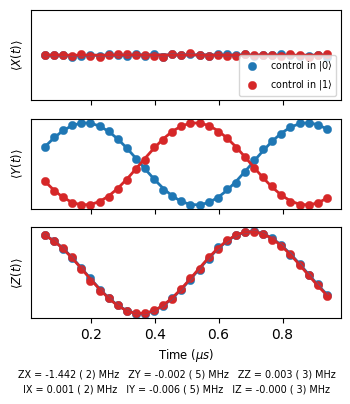

2024-04-25 13:01:53,471, MainThread 
INFO Updated coupling strength: {'IX': 0.001152185644294166, 'IY': -0.006288754074383516, 'IZ': -0.0003438913976852816, 'ZX': -1.4419626752639707, 'ZY': -0.0015715754659830032, 'ZZ': 0.003076394272402093}
2024-04-25 13:01:53,473, MainThread 
INFO IY-DRAG calibration complete, new calibration data saved.


In [18]:
iy_drag_calibration((QUBIT_C, QUBIT_T), backend, gate_name, cr_times, session, verbose=True, delta_beta=10.)

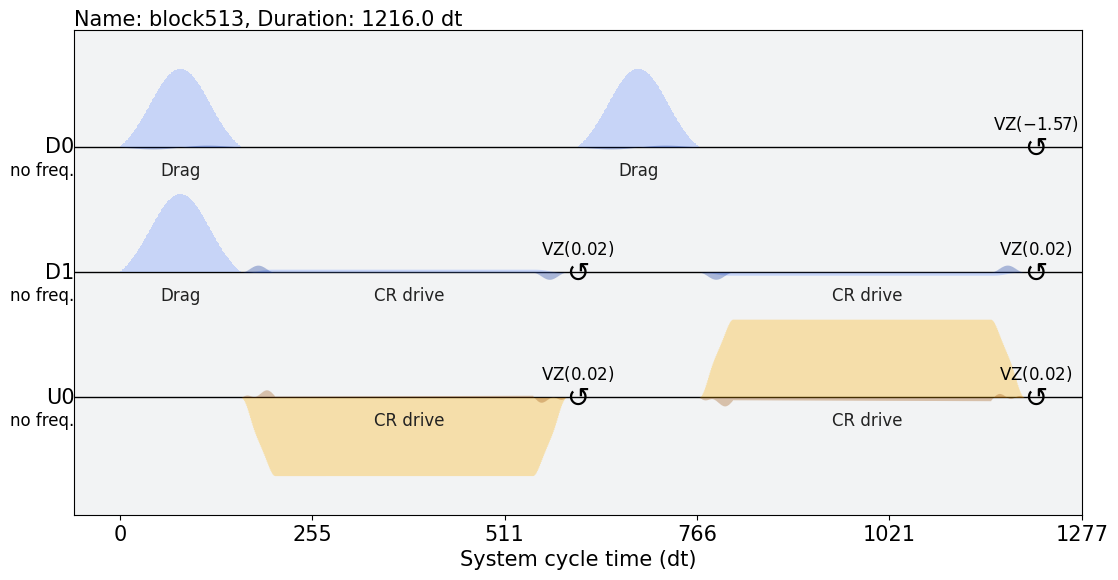

In [19]:
calibration_data = read_calibration_data(backend, gate_name, (QUBIT_C, QUBIT_T))

custom_cnot_sched = create_echoed_cnot_schedule(backend, (QUBIT_C, QUBIT_T), calibration_data, reverse_direction=False)

# Show the custom CNOT schedule.
custom_cnot_sched.draw()